### Analysis

* On average, urban cities have a lot more drivers per city than suburban and rural cities.
* Fare per ride in urban cities tend to be lower than in subruban and rural cities.
* If fare is only dependent on ride distance, then this would suggest that urban rides tend to be shorter on average than suburban and rural rides; if fare is also determined by market competition, then this data would suggest that urban drivers have much more competition within each city than do rural and suburban drivers.

In [1]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load both files
ride_df = pd.read_csv("raw_data/ride_data.csv")
city_df = pd.read_csv("raw_data/city_data.csv")

In [3]:
# Take a look at the rides file
print(ride_df.columns)
print(len(ride_df))
# ride_df.head()

Index(['city', 'date', 'fare', 'ride_id'], dtype='object')
2375


In [4]:
# Take a look at the cities file
print(city_df.columns)
print(len(city_df))

# city_df.head()

Index(['city', 'driver_count', 'type'], dtype='object')
126


In [5]:
# Merge the two dataframes by city
comb_df = pd.merge(ride_df, city_df, on="city", how="left")

# Check the length of comb_df against length of 
print(len(comb_df))

comb_df.head()

2407


,city,date,fare,ride_id,driver_count,type
0,Sarabury,2016-01-16 13:49:27,38.35,5403689035038,46,Urban
1,South Roy,2016-01-02 18:42:34,17.49,4036272335942,35,Urban
2,Wiseborough,2016-01-21 17:35:29,44.18,3645042422587,55,Urban
3,Spencertown,2016-07-31 14:53:22,6.87,2242596575892,68,Urban
4,Nguyenbury,2016-07-09 04:42:44,6.28,1543057793673,8,Urban


The length of the merged dataframe is not the same as the length of the rides dataframe. I suspect there might be repeats in the "city" column of the city dataframe.

In [6]:
# Group by city name and see if any of them come up more than once
city_check = city_df.groupby("city")
city_check.count().sort_values("type", ascending=False).head()

,driver_count,type
city,,
Port James,2,2
Alvarezhaven,1,1
Prattfurt,1,1
South Joseph,1,1
South Jennifer,1,1


Yep, Port James came up twice. Let's look at it.

In [7]:
# Look at the Port James rows
print(city_df.loc[city_df["city"] == "Port James"])

           city  driver_count      type
84   Port James            15  Suburban
100  Port James             3  Suburban


Now, we don't know what's going on here. Maybe there are two cities by them name "Port James", or maybe it got recorded twice due to error. Either way, we will throw out all the data from Port James because it corrupts the data.

In [8]:
# Get rid of the Port James ride data
comb_df = comb_df[comb_df.city != "Port James"]
# print(len(comb_df))

In [9]:
# Organize the data by city
by_city = comb_df.groupby("city")
# by_city.count()

# Make new dataframe to hold the information to plot
# Start with 1st column, average fare
by_city_df = pd.DataFrame(by_city["fare"].mean())
# Add total number of rides column
by_city_df["total_rides"] = by_city["ride_id"].count()
# Add total drivers per city column
by_city_df["drivers_per_city"] = by_city["driver_count"].mean()

# Create and format the city type dataframe
city_type_df = city_df[["city", "type"]]
city_type_df.set_index("city", inplace=True)

# Add the Type column to the graph dataframe
by_city_df = pd.merge(by_city_df, city_type_df, how="left", left_index=True, right_index=True)

# rename the average fare column
by_city_df.rename(columns={"fare": "avg_fare"}, inplace=True)

by_city_df.head()
# city_type_df.head()

,avg_fare,total_rides,drivers_per_city,type
city,,,,
Alvarezhaven,23.928710,31,21,Urban
Alyssaberg,20.609615,26,67,Urban
Anitamouth,37.315556,9,16,Suburban
Antoniomouth,23.625000,22,21,Urban
Aprilchester,21.981579,19,49,Urban


In [10]:
# Separate the dataframe into 3 by city type
urban_df = by_city_df[by_city_df["type"] == "Urban"]
suburban_df = by_city_df[by_city_df["type"] == "Suburban"]
rural_df = by_city_df[by_city_df["type"] == "Rural"]

## Bubble Plot of Ride Sharing Data

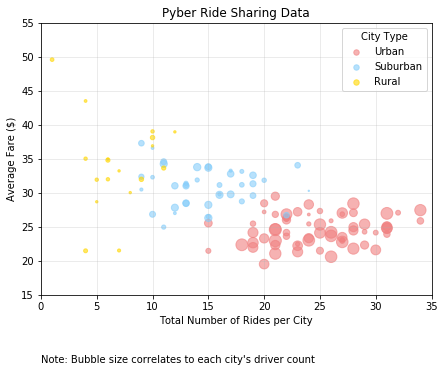

In [21]:
# Set the plot size
plt.figure(figsize=(7,5))

# Plot the 3 sets of data
urb_plt = plt.scatter(urban_df["total_rides"], urban_df["avg_fare"], 
                      s = urban_df["drivers_per_city"]*2, 
                      alpha=0.6, label = "Urban", color="lightcoral")
subu_plt = plt.scatter(suburban_df["total_rides"], suburban_df["avg_fare"], 
                       s = suburban_df["drivers_per_city"]*2, 
                       alpha=0.6, label = "Suburban", color="lightskyblue")
rur_plt = plt.scatter(rural_df["total_rides"], rural_df["avg_fare"], 
                      s = rural_df["drivers_per_city"]*2, 
                      alpha=0.6, label = "Rural", color="gold")

# Title it
plt.title("Pyber Ride Sharing Data")

# Set up axes
plt.xlabel("Total Number of Rides per City")
plt.ylabel("Average Fare ($)")
plt.xlim(0, 35)
plt.ylim(15, 55)

# Show grid
plt.grid(alpha=0.3)

# Label legends
legs = plt.legend(title=("City Type"))
legs.legendHandles[0]._sizes = [30]
legs.legendHandles[1]._sizes = [30]
legs.legendHandles[2]._sizes = [30]

# Add Note
plt.text(0, 5, s="Note: Bubble size correlates to each city's driver count")

# Show it
plt.show()

In [12]:
# Group the data by city type
by_type = comb_df.groupby("type")

# Make the data frame
by_type_df = pd.DataFrame(by_type["fare"].sum())
by_type_df["rides_count"] = by_type["ride_id"].count()
by_type_df["driver_count"] = by_type["driver_count"].sum()

# It doesn't really matter, but for consistency, rename the fare total column
by_type_df.rename(columns={"fare": "fare_total"}, inplace=True)

# Fill in the percent columns
by_type_df["fare_pct"] = [row/by_type_df["fare_total"].sum()  for row in by_type_df["fare_total"]]
by_type_df["rides_pct"] = [row/by_type_df["rides_count"].sum()  for row in by_type_df["rides_count"]]
by_type_df["driver_pct"] = [row/by_type_df["driver_count"].sum()  for row in by_type_df["driver_count"]]

by_type_df

,fare_total,rides_count,driver_count,fare_pct,rides_pct,driver_pct
type,,,,,,
Rural,4255.09,125,727,0.067936,0.053350,0.009774
Suburban,18300.07,593,9154,0.292177,0.253094,0.123067
Urban,40078.34,1625,64501,0.639887,0.693555,0.867159


## Total Fares by City Type

In [13]:
# Labels for slices
slice_labels = by_type_df.index.tolist()

# Set colors
colors = ["gold", "lightskyblue", "lightcoral"]

# Set up exlode
explode = (0, 0, 0.05)

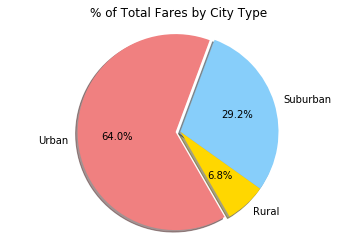

In [14]:
# Set slice sizes
fare_slices = by_type_df.fare_total

# Plot it
plt.pie(fare_slices, colors = colors, 
        labels=slice_labels, autopct="%1.1f%%", 
        startangle=-60,
        explode=explode, shadow=True, radius=1)
plt.axis("equal")

# Title it
plt.title("% of Total Fares by City Type")

# Show it
plt.show()

## Total Rides by CIty Type

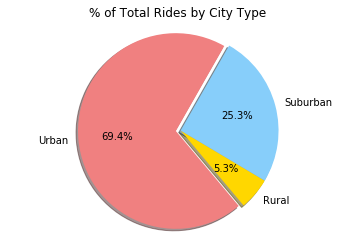

In [15]:
# Set slice sizes
rides_slices = by_type_df.rides_count

# Plot it
plt.pie(rides_slices, colors = colors, 
        labels=slice_labels, autopct="%1.1f%%", 
        startangle=-50,
        explode=explode, shadow=True, radius=1)
plt.axis("equal")

# Title it
plt.title("% of Total Rides by City Type")

# Show it
plt.show()

## Total Drivers by City Type

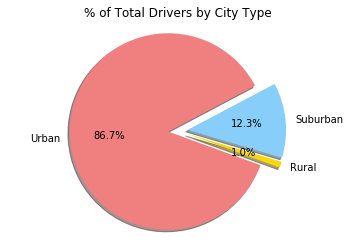

In [16]:
# Set slice sizes
drivers_slices = by_type_df.driver_count

# Set a different explode
explode2 = (0.1, 0.1, 0.1)

# Plot it
plt.pie(drivers_slices, colors = colors, 
        labels=slice_labels, autopct="%1.1f%%", 
        startangle=-20,
        explode=explode2, shadow=True, radius=1)
plt.axis("equal")

# Title it
plt.title("% of Total Drivers by City Type")

# Show it
plt.show()